In [3]:
from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain.agents import AgentExecutor, Tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import Graph, StateGraph, START, END
from langgraph.graph.message import add_messages

from typing_extensions import TypedDict
from typing import Dict, List, Optional, Tuple, Annotated

# from tools import generate_few_shot
from langchain_community.llms import Ollama

### Native calls to LLMs.
#### The output format is dependent on the LLM chosen. 

In [4]:
llm_llama = Ollama(
    base_url='http://localhost:11434',
    model="llama3.2"
)

llm_granite = Ollama(
    base_url='http://localhost:11434',
    model="granite3.1-dense"
)


/var/folders/gd/k9gshwns6mbb7q8c7yldbl9m0000gn/T/ipykernel_23355/491454016.py:1: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm_llama = Ollama(


In [6]:
import json 
with open(
    "/Users/dhaval/Projects/Usage-Governance/agentic-governance/data/risk_questionnaire_examples.json"
) as f:
    cot = json.load(f)
print(cot)

[{'question': 'In which environment is the system used?', 'examples': {'answers': ["Insurance Claims Processing or Risk Management or Data Analytics \nExplanation: 1. Insurance Claims Processing: The system might be used by an insurance company's claims processing department to analyze and identify patterns in healthcare insurance claims. 2. Risk Management: The system could be applied in risk management teams to detect potential risks and opportunities for cost savings. 3. Data Analytics: The system might be used by a data analytics team within the healthcare insurance company to identify patterns in claims data, helping to inform business decisions.", 'Municipal Waste Management or Private Waste Management departments \nExplanation: Waste management companies need to efficiently collect and process waste while minimizing costs and environmental impact. By using generative AI to analyze historical data on waste generation, recycling rates, and resource utilization, they can optimize c

In [7]:
cot_question = cot["3"]["question"]
cot_answers = cot["3"]["examples"]["answers"]
cot_intents = cot["3"]["examples"]["intents"]
cot_explanations = cot["3"]["examples"]["explanations"]
usecase = "Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interactions with customers."

TypeError: list indices must be integers or slices, not str

### Function calling with LLMs.
#### The output format should be independent on the LLM chosen. 

In [ ]:
from langchain_core.messages import AIMessage
from langgraph.graph import END, StateGraph
from typing import TypedDict
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate


In [ ]:
from langchain_ollama import ChatOllama

ollama = ChatOllama(
    model = "llama3.2",
    temperature = 0.,
    num_predict = 256,
    # other params ...
)

In [ ]:
from pydantic import BaseModel, Field

class AITaskFormat(BaseModel):
    """AI Task Format."""
    answer: str = Field(description="AI Tasks")
    question: str = Field(description="The question on prompt relevance")
    explanation: int = Field(description="Explanations for why the prompt is relevant or not relevant")

In [ ]:
# Reference: https://blog.gopenai.com/zeroshot-fewshot-and-prompt-chaining-using-langchain-4259d700d67f
class FewShot:
    def __init__(self):
        self.examples = []
        self.prefix = f"""
        I want you to play the role of a compliance officer and answer the question
        Return the question, answer and explanation in a json format where question, answer and explanation are keys of the json exactly as shown in the examples.
        you should answer the question followed by an explanation on how that answer was generated. 
        """

    def set_examples(self, examples):
        self.examples = examples
        return self.examples

    def get_examples(self):
        return self.examples

    def get_example_template(self):
        template = """
        Question: {question}
        Answer: {answer}
        """
        example_variables = ["question", "answer", "explanation"]
        return template, example_variables

    def get_prefix(self):
        return f"""
        I want you to play the role of a compliance officer and answer the question
        Return the question, answer and explanation in a json format where question, answer and explanation are keys of the json exactly as shown in the examples.
        you should answer the question followed by an explanation on how that answer was generated. 
        """

    def get_suffix(self):
        return """
                Question: {question}
                """

In [ ]:
# Reference: https://blog.gopenai.com/zeroshot-fewshot-and-prompt-chaining-using-langchain-4259d700d67f

import os
from langchain import PromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate


class FewShotUtility:

    def __init__(self, examples, prefix, suffix, input_variables, example_template, example_variables):
        self.examples = examples
        self.prefix = prefix
        self.suffix = suffix
        self.input_variables = input_variables
        self.example_template = example_template
        self.example_variables = example_variables

    def get_prompt(self, question):
        prompt_template = FewShotPromptTemplate(
            examples=self.examples,
            example_prompt=self.get_prompt_template(),
            prefix=self.prefix,
            suffix=self.suffix,
            input_variables=self.input_variables
        )
        prompt = prompt_template.format(question=question)
        return prompt

    def get_prompt_template(self):
        example_prompt = PromptTemplate(
            input_variables=self.example_variables,
            template=self.example_template
        )
        return example_prompt

    def get_ai_tasks(self, prompt):
        prompt_template = ChatPromptTemplate.from_template(prompt)
        message = prompt_template.format_messages()
        structured_llm = ollama.with_structured_output(AITaskFormat, method="function_calling")
        response = structured_llm.invoke(message)
        return response


In [10]:
from typing import Optional

from typing_extensions import Annotated, TypedDict


# TypedDict
class AITaskFormat(TypedDict):

    question: Annotated[str, ..., "The question and use case of the prompt"]
    answer: Annotated[str, ..., "The AI tasks for the use case"]
    explanation: Annotated[str, None, "Explanations for why the AI tasks were selected"]

In [ ]:
fewshot = FewShot()
examples = []
for i in range(len(cot_answers)):
    examples.append({"question": "For the usecase:" + cot_intents[i] + cot_question, "answer": cot_answers[i], "explanation": cot_explanations[i]})
    
fewshot.set_examples(examples=examples)

[{'question': 'For the usecase:Find patterns in healthcare insurance claimsWho is the intended user of the system?',
  'answer': ' Insurance companies, government agencies, or other organizations responsible for reimbursing healthcare providers ',
  'explanation': ' Healthcare payers need to efficiently process and reimburse claims while minimizing errors and disputes. By identifying patterns in claims data, they can automate routine tasks, detect potential errors or anomalies, and improve overall payment accuracy'},
 {'question': 'For the usecase:Generative AI can optimize waste management processes. By analyzing historical data on waste generation, recycling rates, and resource utilization, generative models can generate optimized waste collection routes, recommend recycling strategies, and predict waste generation patterns. This helps in reducing waste generation, optimizing resource allocation, and promoting circular economy practices.Who is the intended user of the system?',
  'an

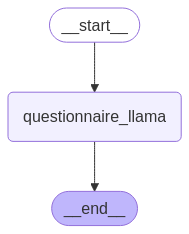

Find AI task:
Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interactions with customers.

--- --- ---

AI task
Insurance companies, government agencies, or other organizations responsible for reimbursing healthcare providers

--- --- ---



In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class AI_TASK(TypedDict):
    question: str
    answer: str
    explanation: str

class State(TypedDict):
    intent: str
    ai_task: AI_TASK


# Nodes
def generate_zero_shot(state: State):
    msg = llm_llama.invoke(f"{state['intent']}")
    return {"ai_task": msg}


# Nodes
def generate_few_shot_llama(state: State):
    examples = fewshot.get_examples()
    prefix = fewshot.get_prefix()
    suffix = fewshot.get_suffix()
    example_template, example_variables = fewshot.get_example_template()
    fewShot = FewShotUtility(examples=examples,
                            prefix=prefix,
                            suffix=suffix,
                            input_variables=["question"],
                            example_template=example_template,
                            example_variables=example_variables
                            )
    question = "For the usecase: " + state['intent'] + "," + cot_question

    prompt = fewShot.get_prompt(question)
    msg = fewShot.get_ai_tasks(prompt)

    return {"ai_task": msg}



# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("questionnaire_llama", generate_few_shot_llama)



# Add edges to connect nodes
workflow.add_edge(START, "questionnaire_llama")

workflow.add_edge("questionnaire_llama", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"intent":usecase})

print("Find AI task:")
print(state["intent"])
print("\n--- --- ---\n")
print("AI task")
print(state["ai_task"]["answer"])
print("\n--- --- ---\n")
